In [1]:
import numpy as np
from scipy import misc
import pprint as pp
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Activation, Input
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler, History
from keras.utils import np_utils
from keras.optimizers import Adam
from keras import backend as Keras
from keras.applications import ResNet50

from sklearn import metrics
from scipy.spatial import distance

import json
import time

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/albert/github/DenseNet/')
sys.path.append('/home/albert/github/tensorflow/')
import densenet
import triplet

### Mine Triplets

In [3]:
CAFFE_ROOT = '/home/albert/caffe/'
train_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')
test_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_test')

In [4]:
train_dict = {}
train_files = []
train_labels = []

for f in train_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if not any(idt == l for l in train_labels):
            train_labels.append(idt)
            train_dict[idt] = []
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        train_files.append([path, idt])
        train_dict[idt].append(path)

train_labels.sort()

test_dict = {}
test_files = []
test_labels = []

for f in test_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if idt != 0 and idt != -1:
            if not any(idt == l for l in test_labels):
                test_labels.append(idt)
                test_dict[idt] = []
            path = CAFFE_ROOT + 'data/market-1501/bounding_box_test/' + f
            test_files.append([path, idt])
            test_dict[idt].append(path)
        
test_labels.sort()

In [5]:
print train_files[0]

['/home/albert/caffe/data/market-1501/bounding_box_train/0575_c6s2_004068_01.jpg', 575]


In [6]:
print test_files[0]

['/home/albert/caffe/data/market-1501/bounding_box_test/0152_c2s1_024601_02.jpg', 152]


### Train Network

In [7]:
def normalize(im):
    return (im * 255.0 / im.max()).astype(np.uint8)

In [8]:
# Number of identities
P_param = 18
# Number of images per identity
K_param = 4

In [9]:
def makeGaussian(shape, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, np.array(shape).max(), 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)[0:shape[0], 0:shape[1]]

In [30]:
def overlay_keypoints(img_path, train=False):
    if img_path.find('/') > -1:
        root = img_path[len(img_path) - img_path[::-1].index('/'):-4:]
    else:
        root = img_path[0:img_path.index('.')]
    
    img = misc.imread(img_path)
    htmp = np.zeros((128,64)).astype(np.float32)
    
    if train:
        keypoint_path = CAFFE_ROOT + \
                    'data/market-1501/train_openpose/train_keypoints/%s_keypoints.json' % root
    else:
        keypoint_path = CAFFE_ROOT + \
                    'data/market-1501/test_openpose/test_keypoints/%s_keypoints.json' % root
    with open(keypoint_path) as data_file:    
        data = json.load(data_file)
    for person in range(len(data['people'])):
        for i in range(0, len(data['people'][person]['pose_keypoints']), 3):
            x_key = data['people'][person]['pose_keypoints'][i]
            y_key = data['people'][person]['pose_keypoints'][i + 1]
            c_key = data['people'][person]['pose_keypoints'][i + 2]
            if not (x_key == 0 and y_key == 0):
                htmp += makeGaussian((128,64), fwhm=10, center=(x_key, y_key))

    if htmp.max() > 0.0:
        htmp = np.array([[3*[j/htmp.max()] for j in row] for row in htmp.tolist()])
    else:
        htmp = np.array([[3*[j] for j in row] for row in htmp.tolist()])
    return (img*htmp).astype(np.uint8)

In [11]:
def output_batch_generator(files_dict, labels, P=P_param, K=K_param):
    while True:
        batch = []
        idt_choice = np.random.choice(labels, P, replace=False)
        for p in range(len(idt_choice)):
            if K > len(files_dict[idt_choice[p]]):
                k_choice = np.random.choice(range(len(files_dict[idt_choice[p]])), K, replace=True)
            else:
                k_choice = np.random.choice(range(len(files_dict[idt_choice[p]])), K, replace=False)            
#             print k_choice, p
            for k in k_choice:
                img_path = files_dict[idt_choice[p]][k]
                batch.append(overlay_keypoints(img_path).tolist())
        output = np.array(batch, dtype=np.uint8)
        yield(output, np.zeros((P*K, 128)))

5.41006016731


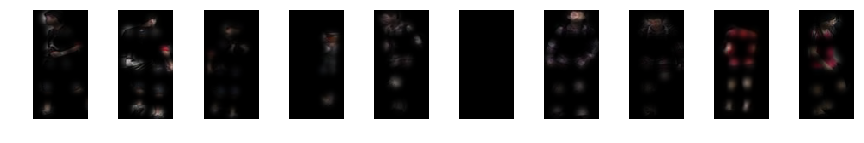

In [12]:
start = time.time()
train_batch = output_batch_generator(train_dict, train_labels).next()
print time.time() - start
plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_batch[0][i])
    plt.axis('off')
plt.show()

In [13]:
def log1p(x):
    return Keras.log(1 + Keras.exp(x))

In [14]:
def dist(x1, x2):
    return Keras.sum(Keras.abs(x1 - x2), axis=1)

In [15]:
def triplet_loss(y_true, y_pred, margin=0.5, P=P_param, K=K_param, output_dim = 128):
    embeddings = Keras.reshape(y_pred, (-1, output_dim))

    loss = tf.Variable(1, dtype=tf.float32)

    for i in range(P):
        for a in range(K):
            pred_anchor = embeddings[i*K + a]
            hard_pos = Keras.max(dist(pred_anchor, embeddings[i*K:(i + 1)*K]))
            hard_neg = Keras.min(dist(pred_anchor, Keras.concatenate([embeddings[0:i*K],
                                                                      embeddings[(i + 1)*K:]], 0)))
            loss += margin + hard_pos - hard_neg
    return loss

In [16]:
def evaluate_rank(net, rank, all_embeddings, all_identities, files_arr, test_iter=1000, shape=(128,64)):
    correct = 0
    f_choice = np.random.choice(range(len(files_arr)), np.minimum(test_iter, len(files_arr)), replace=False)
    for f in f_choice:
        query_img = overlay_keypoints(files_arr[f][0])
        query_embedding = net.predict(query_img.reshape(1, shape[0], shape[1], 3))
        distance_vectors = np.squeeze(np.abs(all_embeddings - query_embedding))
        distance = np.sum(distance_vectors, axis=1)
        top_inds = distance.argsort()[:rank+1]
        output_classes = np.array(all_identities)[top_inds].astype(np.uint16)
        
        i = 0
        for c in output_classes:
            if c == int(files_arr[f][1]):
                i += 1
        if i > 1:
            correct += 1
    return float(correct)/test_iter

In [17]:
def pos_pair_generator(files_dict):
    while True:
        idt = np.random.choice(files_dict.keys(), 1, replace=False)[0]
        sample_choice = np.random.choice(range(len(files_dict[idt])), np.minimum(2, len(files_dict[idt])), replace=False)
        pair = [overlay_keypoints(files_dict[idt][p]).tolist() for p in sample_choice]
        yield(np.array(pair).astype(np.uint8))

In [18]:
def neg_pair_generator(files_dict):
    while True:
        idt_choice = np.random.choice(files_dict.keys(), 2, replace=False)
        pair = []
        for idt in idt_choice:
            sample = np.random.choice(range(len(files_dict[idt])), 1, replace=False)[0]
            pair.append(overlay_keypoints(files_dict[idt][sample]).tolist())
        yield(np.array(pair).astype(np.uint8))

In [19]:
def l2(x1, x2):
    l2 = np.sqrt(np.sum(np.power(x1 - x2, 2)))
    return l2

In [20]:
def evaluate_dist(model, generator, n_pairs=1000):
    distances = []
    for t in range(n_pairs):
        pair = generator.next()   
        predict = [model.predict(pair[i].reshape(1,128,64,3)) for i in range(2)]
        dist = distance.cosine(predict[0], predict[1])
        distances.append(dist)
    return distances

In [21]:
def get_score(model, files_dict, files_arr, file_root, score, iterations, history=False):
    all_embeddings = []
    all_identities = []
    for idt in files_dict.keys():
        for f in files_dict[idt]:
            predict = model.predict(overlay_keypoints(f).reshape(1, 128, 64, 3))
            all_embeddings.append(predict)
            all_identities.append(idt)

    for rank in [1,5,20]:
        rank_arr = []
        for x in range(3):
            rank_score = evaluate_rank(model, rank, all_embeddings, 
                                       all_identities, files_arr, test_iter=1000)
            rank_arr.append(rank_score)
        score['rank%d' % rank][iterations] = rank_arr
    
    pos_generator = pos_pair_generator(files_dict)
    neg_generator = neg_pair_generator(files_dict)
    
    pos_distance = evaluate_dist(model, pos_generator)
    score['pos_distance'][iterations] = pos_distance
    
    neg_distance = evaluate_dist(model, neg_generator)
    score['neg_distance'][iterations] = neg_distance
    
    score['precision'][iterations] = []
    score['recall'][iterations] = []
    score['matt_coef'][iterations] = []
    
    for thresh in np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:]:
        true = np.ones(len(pos_distance)).tolist() + np.zeros(len(neg_distance)).tolist()
        pred_pos = [int(d < thresh) for d in pos_distance]
        pred_neg = [int(d < thresh) for d in neg_distance]
        pred = pred_pos + pred_neg

        score['precision'][iterations].append(metrics.precision_score(true, pred))
        score['recall'][iterations].append(metrics.recall_score(true, pred))
        score['matt_coef'][iterations].append(metrics.matthews_corrcoef(true, pred))
    
    if history:
        score['loss'] += history.history['loss']
    
    file_name = file_root + '_' + str(iterations) + '.h5'
    score['file_name'][iterations] = file_name
    
    return score

In [26]:
score = {
    'rank1' : {},
    'rank5' : {},
    'rank20' : {},
    'pos_distance' : {},
    'neg_distance' : {},
    'precision' : {},
    'recall' : {},
    'matt_coef' : {},
    'loss' : [],
    'file_name' : {}
}

# test_score = {
#     'rank1' : {},
#     'rank5' : {},
#     'rank20' : {},
#     'pos_distance' : {},
#     'neg_distance' : {},
#     'precision' : {},
#     'recall' : {},
#     'matt_coef' : {},
#     'loss' : [],
#     'file_name' : {}
# }

In [27]:
# ./build/examples/openpose/openpose.bin --image_dir /home/albert/caffe/data/market-1501/bounding_box_test/ --write_images /home/albert/caffe/data/market-1501/test_openpose/test_render/ --write_keypoint_json /home/albert/caffe/data/market-1501/test_openpose/test_keypoints/ --heatmaps_add_parts --heatmaps_add_bkg --heatmaps_add_PAFs --write_heatmaps /home/albert/caffe/data/market-1501/test_openpose/test_heatmaps/ --resolution 64x128

In [31]:
epochs = 10
steps_per_epoch = 100

file_root = 'densenet_triplet_keypoint'
trinet = load_model('/home/albert/github/tensorflow/models/densenet_triplet_keypoint/densenet_triplet_keypoint_3000.h5',
                        custom_objects={'triplet_loss':triplet_loss})

era = 3
iterations = era * steps_per_epoch * epochs

# train_score = get_score(trinet, train_dict, train_files, file_root, train_score, iterations)
# test_score = get_score(trinet, test_dict, test_files, file_root, test_score, iterations)

all_embeddings = []
all_identities = []
z = 1
start = time.time()
for idt in test_dict.keys():
    for f in test_dict[idt]:
        predict = trinet.predict(overlay_keypoints(f).reshape(1, 128, 64, 3))
        all_embeddings.append(predict)
        all_identities.append(idt)
        if z % 1000 == 0:
            print z, time.time() - start
        z += 1

1000 76.0671591759
2000 148.062248945
3000 219.428995132
4000 289.906993151
5000 361.498382092
6000 433.048112154
7000 505.037752151
8000 577.023796082
9000 648.762999058
10000 720.793956995
11000 793.331936121
12000 864.400030136
13000 937.083024025


In [32]:
for rank in [1,5,20]:
    rank_arr = []
    for x in range(3):
        rank_score = evaluate_rank(trinet, rank, all_embeddings, 
                                   all_identities, test_files, test_iter=1000)
        rank_arr.append(rank_score)
    score['rank%d' % rank][iterations] = rank_arr

pos_generator = pos_pair_generator(test_dict)
neg_generator = neg_pair_generator(test_dict)

In [33]:
pos_distance = evaluate_dist(trinet, pos_generator)
score['pos_distance'][iterations] = pos_distance

neg_distance = evaluate_dist(trinet, neg_generator)
score['neg_distance'][iterations] = neg_distance

score['precision'][iterations] = []
score['recall'][iterations] = []
score['matt_coef'][iterations] = []

for thresh in np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:]:
    true = np.ones(len(pos_distance)).tolist() + np.zeros(len(neg_distance)).tolist()
    pred_pos = [int(d < thresh) for d in pos_distance]
    pred_neg = [int(d < thresh) for d in neg_distance]
    pred = pred_pos + pred_neg

    score['precision'][iterations].append(metrics.precision_score(true, pred))
    score['recall'][iterations].append(metrics.recall_score(true, pred))
    score['matt_coef'][iterations].append(metrics.matthews_corrcoef(true, pred))

file_name = file_root + '_' + str(iterations) + '.h5'
score['file_name'][iterations] = file_name

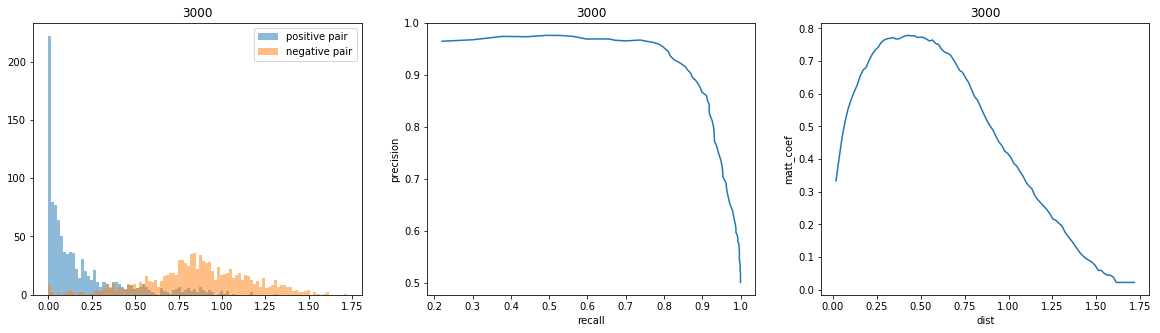

rank1 [0.472, 0.488, 0.504]
rank5 [0.753, 0.752, 0.701]
rank20 [0.874, 0.874, 0.848]


In [34]:
for score in [score]:
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    pos_distance = score['pos_distance'][iterations]
    neg_distance = score['neg_distance'][iterations]
    bins = np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 100)
    plt.hist(pos_distance, bins, alpha=0.5, label='positive pair')
    plt.hist(neg_distance, bins, alpha=0.5, label='negative pair')
    plt.legend(loc='upper right')
    plt.title(str(iterations))

    plt.subplot(1,3,2)
    plt.plot(score['recall'][iterations], score['precision'][iterations])
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title(str(iterations))

    plt.subplot(1,3,3)
    plt.plot(np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:], 
             score['matt_coef'][iterations])
    plt.xlabel('dist')
    plt.ylabel('matt_coef')
    plt.title(str(iterations))
    plt.show()

    print 'rank1', score['rank1'][iterations]
    print 'rank5', score['rank5'][iterations]
    print 'rank20', score['rank20'][iterations]

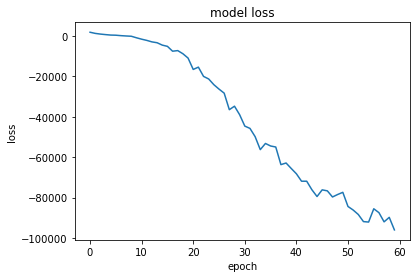

In [34]:
# summarize history for loss
plt.plot(score['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [35]:
train_rank1_avg = []
train_rank5_avg = []
train_rank20_avg = []
test_rank1_avg = []
test_rank5_avg = []
test_rank20_avg = []

for iterations in train_score['rank5'].keys():
    train_rank1_avg.append(np.average(np.array(train_score['rank1'][iterations])))
    train_rank5_avg.append(np.average(np.array(train_score['rank5'][iterations])))
    train_rank20_avg.append(np.average(np.array(train_score['rank20'][iterations])))
    test_rank1_avg.append(np.average(np.array(test_score['rank1'][iterations])))
    test_rank5_avg.append(np.average(np.array(test_score['rank5'][iterations])))
    test_rank20_avg.append(np.average(np.array(test_score['rank20'][iterations])))

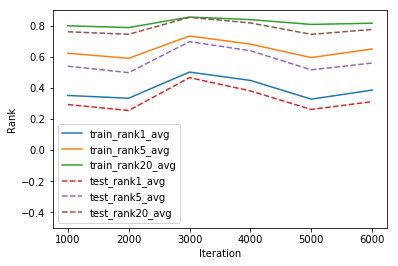

In [37]:
iterations = 6000
plt.plot(np.arange(1000,iterations+1000,1000), train_rank1_avg, label='train_rank1_avg', )
plt.plot(np.arange(1000,iterations+1000,1000), train_rank5_avg, label='train_rank5_avg', )
plt.plot(np.arange(1000,iterations+1000,1000), train_rank20_avg, label='train_rank20_avg')

plt.plot(np.arange(1000,iterations+1000,1000), test_rank1_avg, label='test_rank1_avg', linestyle='--')
plt.plot(np.arange(1000,iterations+1000,1000), test_rank5_avg, label='test_rank5_avg', linestyle='--')
plt.plot(np.arange(1000,iterations+1000,1000), test_rank20_avg, label='test_rank20_avg', linestyle='--')
plt.legend(loc='lower left')
plt.xlabel('Iteration')
plt.ylabel('Rank')
plt.ylim(-0.5,0.9)
plt.show()

In [35]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_test_score_2.npz' % (file_root, file_root), score)
# np.savez('/home/albert/github/tensorflow/models/%s/%s_test_score.npz' % (file_root, file_root), test_score)